In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from src import hrNet
from src import readFrames

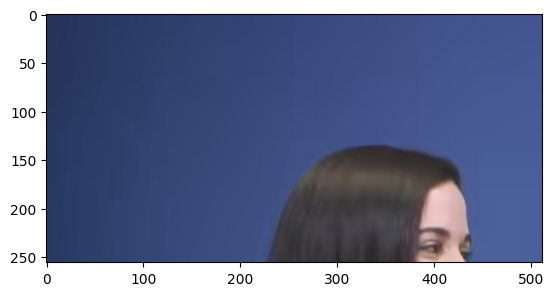

In [2]:
patch_tmin1, patch_t, patch_tplus1 = readFrames("KristenAndSara_10frames_512x256.yuv420p",[512,256],1,7)

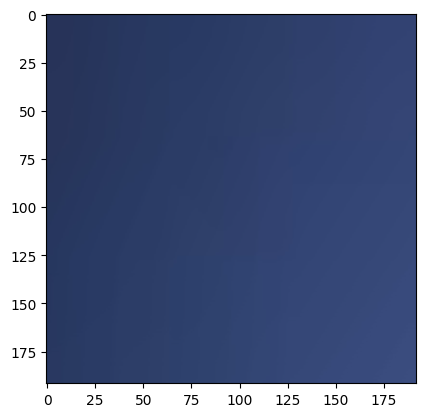

In [3]:
patch_tSmall = patch_t[:192,:192,:]
plt.imshow(patch_tSmall/255.0)

In [4]:
inputPatches = np.concatenate((patch_tSmall,patch_tSmall,patch_tSmall),axis=-1)
inputPatches = np.expand_dims(inputPatches,axis=0)

In [5]:
hrNetModel = hrNet(2, [32, 64, 128, 256], 5).model()

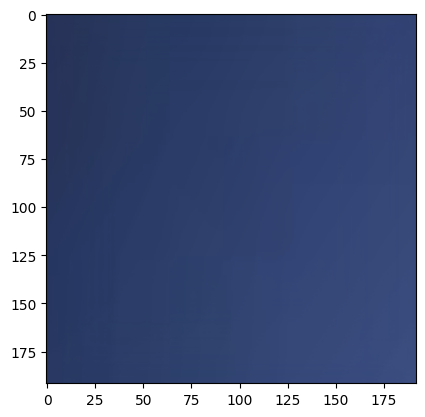

In [13]:
outputPatch = hrNetModel(inputPatches,training=False)
plt.imshow(outputPatch[0]/255.0)

In [8]:
import lpips
import torch
from src import image_preprocess

In [32]:
class lpipsClass():
    def __init__(self):
        self.loss_fn_vgg = lpips.LPIPS(net='vgg') # closer to "traditional" perceptual loss, when used for optimization

    def lpipsLossFunc(self, x, y):
        x, y = torch.tensor(x), torch.tensor(y)
        d = self.loss_fn_vgg(x, y)
        return d

    def computeLpipsFrame(self,restored_frame : tf.Tensor,original_frame : tf.Tensor):
        img0 = restored_frame
        img0 = image_preprocess(img0)
        img0 = tf.transpose(img0,perm=[0,3,1,2])
        #img0 = np.expand_dims(img0,axis=0)
        #img0 = np.moveaxis(img0,-1,1)
        #img0 = np.float32(img0)
        img0 = img0.numpy()
        # the restored frame
        img1 = original_frame
        img1 = image_preprocess(original_frame)
        img1 = tf.transpose(img1,perm=[0,3,1,2])
        img1 = img1.numpy()
        #img1 = np.expand_dims(img1,axis=0)
        #img1 = np.moveaxis(img1,-1,1)
        #img1 = np.float32(img1)
        # Converting from numpy to pytorch
        img0 = torch.tensor(img0)
        img1 = torch.tensor(img1)

        return self.lpipsLossFunc(img0,img1)

In [36]:
lpipsInst = lpipsClass()

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: c:\Users\victo\anaconda3\envs\hrNet\lib\site-packages\lpips\weights\v0.1\vgg.pth


In [37]:
hrNetModel.compile(run_eagerly=True,optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),loss=lpipsInst.computeLpipsFrame)

In [38]:
hrNetModel.fit(inputPatches[:,:,:,:],inputPatches[:,:,:,:3],epochs=1)

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [1]:
from subprocess import run

In [2]:
run("ffmpeg -version",capture_output=True, shell=True).stdout.decode("utf-8").rstrip("\n")

'ffmpeg version 2022-10-24-git-d79c240196-full_build-www.gyan.dev Copyright (c) 2000-2022 the FFmpeg developers\r\nbuilt with gcc 12.1.0 (Rev2, Built by MSYS2 project)\r\nconfiguration: --enable-gpl --enable-version3 --enable-static --disable-w32threads --disable-autodetect --enable-fontconfig --enable-iconv --enable-gnutls --enable-libxml2 --enable-gmp --enable-bzlib --enable-lzma --enable-libsnappy --enable-zlib --enable-librist --enable-libsrt --enable-libssh --enable-libzmq --enable-avisynth --enable-libbluray --enable-libcaca --enable-sdl2 --enable-libaribb24 --enable-libdav1d --enable-libdavs2 --enable-libuavs3d --enable-libzvbi --enable-librav1e --enable-libsvtav1 --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs2 --enable-libxvid --enable-libaom --enable-libjxl --enable-libopenjpeg --enable-libvpx --enable-mediafoundation --enable-libass --enable-frei0r --enable-libfreetype --enable-libfribidi --enable-liblensfun --enable-libvidstab --enable-libvmaf --enable-l